# DSCI 100 Final Project
## Group 33

### Introduction

#### Background information:
A Computer Science research team at UBC led by Frank Wood set up a Minecraft server, recording player's actions to explore how people play video games. We wanted to figure out which player characteristics or behaviours could be used to predict their subscription status to the game-related newsletter.

#### Question:
Can player’s hours played, age  and experience level predict whether a player is subscribed to the game-related newsletter?

#### Data Set
The data set we used to answer this question was the Player’s Dataset (players.csv). The dataset contains 196 observations and 7 variables, including player's experience, age, gender, email, name, subscription status and hours played. However the variables of interest for answering this question are age, experience and hours played.<br /><br />
**Description for each variable in data set**
  - **experience**: Player's experience level, type is character.
  - **subscribe**: Indicates whether the player has a subscription, type is logical (52 False, 144 TRUE).
  - **hashedEmail**: Hashed email ID for player identification, type is character.
  - **played_hours**: Total number of hours the player has played, type is double.
  - **name**: Player's name, type is character.
  - **gender**: Player's gender, type is character.
  - **Age**: Player's age, type is double.


### Methods & Results

The first step is to load the data.

In [2]:
# Load the required packages
library(tidyverse)
library(repr)
library(tidymodels) 
library(gridExtra)

# Load data
player_data<-read_csv("data/players.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

We will now tidy the data set by adding median to blank values in age data. To be able to continue with a classification model, we will transform subscribe from a logical data type to a factor, and also turn experience levels into a numerical scale of 5.

In [3]:
# select needed variable
player_data <- select(player_data,subscribe,played_hours,Age,experience) 

# add median for NA age data
player_data$Age[is.na(player_data$Age)] <- median(player_data$Age, na.rm = TRUE) 

# change subscribe data types from character and logical to factors
player_data <- mutate(player_data,subscribe = as_factor(subscribe))

# change experience level to numeric type for knn model
player_data <- mutate(player_data, 
                      experience = recode(experience, 
                                          Beginner = 1,
                                          Amateur = 2,
                                          Regular = 3, 
                                          Pro = 4,
                                          Veteran = 5))

#### Data Set Summary

Here we have a summary of the relevant data set being used for the analysis.

In [4]:
#Generate summary
head(player_data,5) 
summary(player_data) 

subscribe,played_hours,Age,experience
<fct>,<dbl>,<dbl>,<dbl>
TRUE,30.3,9,4
TRUE,3.8,17,5
FALSE,0.0,17,5
TRUE,0.7,21,2
TRUE,0.1,21,3


 subscribe    played_hours          Age          experience   
 FALSE: 52   Min.   :  0.000   Min.   : 8.00   Min.   :1.000  
 TRUE :144   1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:2.000  
             Median :  0.100   Median :19.00   Median :2.500  
             Mean   :  5.846   Mean   :20.51   Mean   :2.883  
             3rd Qu.:  0.600   3rd Qu.:22.00   3rd Qu.:4.000  
             Max.   :223.100   Max.   :50.00   Max.   :5.000  

**Table1: Summary of numeric varibles**
| Variable          | Class      | Min     | 1st Quartile | Median | Mean  | 3rd Quartile | Max    | NA's |
|------------------|-----------|--------|--------|--------|--------|--------|--------|------|
| **played_hours** | double    | 0.000  | 0.000  | 0.100  | 5.846  | 0.600  | 223.100 | 0    |
| **Age**        | double     | 8.00   | 17.00  | 19.00  | 20.52  | 22.00  | 50.00  | 2    |

#### Data Set Visualization

Then we want to compose data visualization to show the relationships between subscription status and other variables.

Figure 1 shows proportion of subscription rate by played hours range.

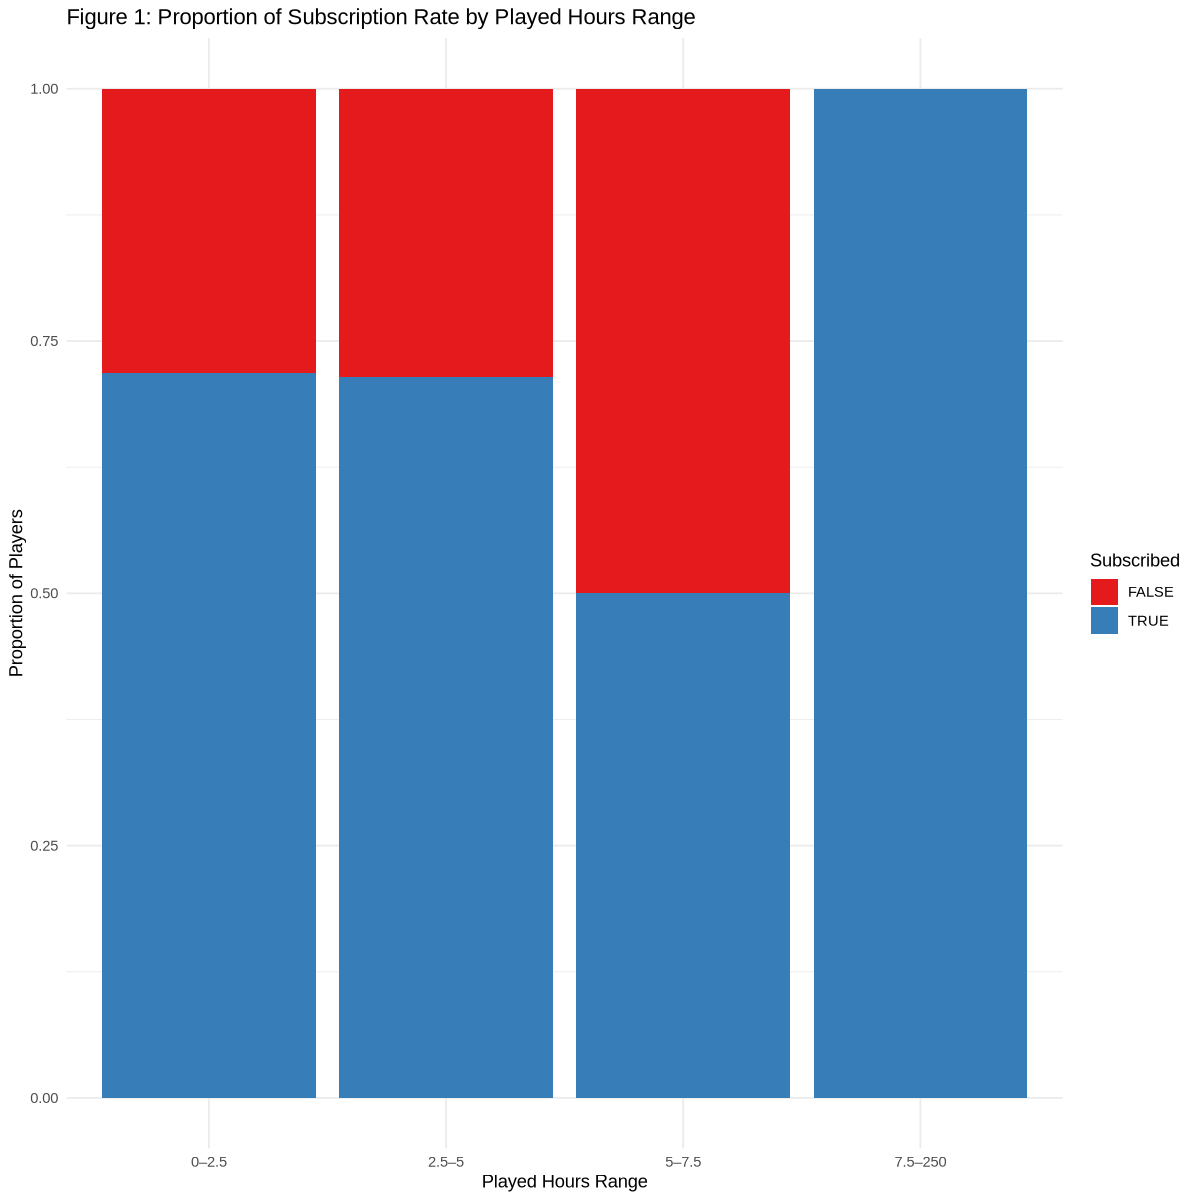

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)
#First create played hour range category
players <- player_data|>
  mutate(hour_group = case_when(
    played_hours >= 0 & played_hours < 2.5 ~ "0–2.5",
    played_hours >= 2.5 & played_hours <= 5 ~ "2.5–5",
    played_hours >= 5 & played_hours < 7.5 ~ "5–7.5",
    played_hours >= 7.5 & played_hours < 250 ~ "7.5–250",
    
    TRUE ~ NA_character_
  ))

#Turn "subscribe" into a factor
players$subscribe <- as.factor(players$subscribe)

#Bar chart: subscription status by hour range
ggplot(players, aes(x = hour_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Figure 1: Proportion of Subscription Rate by Played Hours Range",
    x = "Played Hours Range",
    y = "Proportion of Players",
    fill = "Subscribed"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

Figure 2 shows the proportion of subscription rate by age range.

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
#First create age range category
players1 <- player_data|>
  mutate(age_group = case_when(
    Age >= 0 & Age < 10 ~ "0–10",
    Age >= 10 & Age <= 20 ~ "10–20",
    Age >= 20 & Age < 30 ~ "20–30",
    Age >= 30 & Age < 40 ~ "30–40",
    Age >= 40 & Age < 50 ~ "40–50",
    Age >= 50 & Age < 100 ~ "50–100",
      
    
    TRUE ~ NA_character_
  ))
#Turn "subscribe" into a factor
players$subscribe <- as.factor(players$subscribe)

#Bar chart: subscription status by age range
ggplot(players1, aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Figure 2: Proportion of Subscription Rate by Age Range",
    x = "Age Range",
    y = "Proportion of Players",
    fill = "Subscribed"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

Figure 3 shows the proportion of subscription rate by experience level.

In [1]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Figure 3: Proportion of Subscription rate by Experience Level",
    x = "Experience Level",
    y = "Proportion",
    fill = "Subscribed"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

ERROR: Error in ggplot(player_data, aes(x = experience, fill = subscribe)): could not find function "ggplot"


#### Data Analysis - Classification Model

To effectively analyze the data and determine if we can predict a player's subscription status based off hours played, age and experience level, we will proceed using K-Nearest Neighbors classification model, because KNN classification fits natually to our classification problem. KNN handles relationships between numerical predictor, categorical predictor and categorical outcomes well, especially if relationships are complex or nonlinear. And also, KNN classification do not need any assumptions. The accuracy of this model will be evaluated to confirm whether it is a good model and providing a conclusion for our question.

To begin the process, we will split the data into a training (75%) and testing set (25%).

In [19]:
set.seed(1234)

#split the data
data_split<-initial_split(player_data, prop = 0.75, strata = subscribe)
data_train<- training(data_split)  
data_test<- testing(data_split)

We will now train the data so that it can find patterns in the dataset to use in predictions.

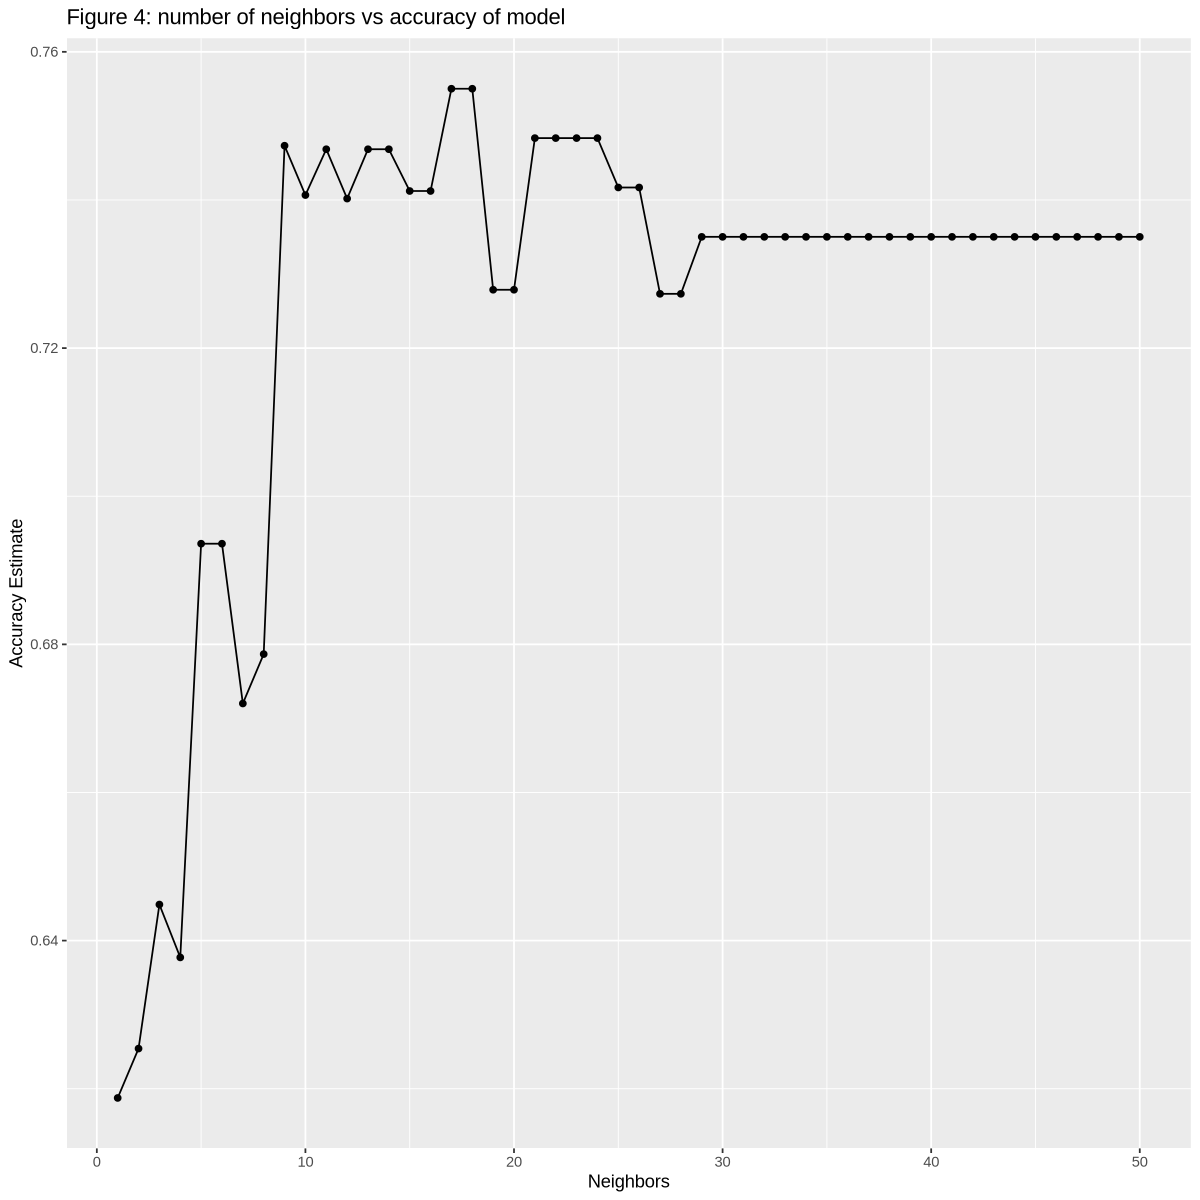

In [20]:
#train the data
data_recipe <- recipe(subscribe ~. , data = data_train)  |>
   step_center(all_predictors())|>
   step_scale(all_predictors())

data_vfold <- vfold_cv(data_train, v = 10, strata = subscribe)

knn_tune<-nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")
                      
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
      add_recipe(data_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = data_vfold, grid = k_vals) |>
      collect_metrics() 

accuracies <- knn_results |> 
      filter(.metric=="accuracy")|> # filter out metric type we want
        arrange(desc(mean))

# plot the number of neighbors vs accuracy of model
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate",title = "Figure 4: number of neighbors vs accuracy of model")
accuracy_versus_k

We choose k value from 0-50 to test and compare our model's accuracy, the result shows the accuracy after k value larger or equal to 30 is same.

In [21]:
# determine best k value to use based on accuracy

best_k_accuracies <- knn_results |> 
# filter out metric type we want
      filter(.metric=="accuracy")|> 
        arrange(desc(mean))|>
        select(neighbors)|>
        slice(1)|>
        pull()
best_k_accuracies

[1] 17

Using this value we can proceed to test the data. This will show whether or not our model learned the patterns in the data.

In [22]:
#test the data
knn_spec<-nearest_neighbor(weight_func = "rectangular",neighbors = best_k_accuracies) |>
     set_engine("kknn") |>
     set_mode("classification")
player_fit <- workflow() |>
      add_recipe(data_recipe) |>
      add_model(knn_spec) |>#spec using finding of k value
      fit(data = data_train)
player_test_predictions <- predict(player_fit, data_test) |>
      bind_cols(data_test)

player_prediction_accuracy <- player_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)  

confusion_mat <- player_test_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class) 
confusion_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

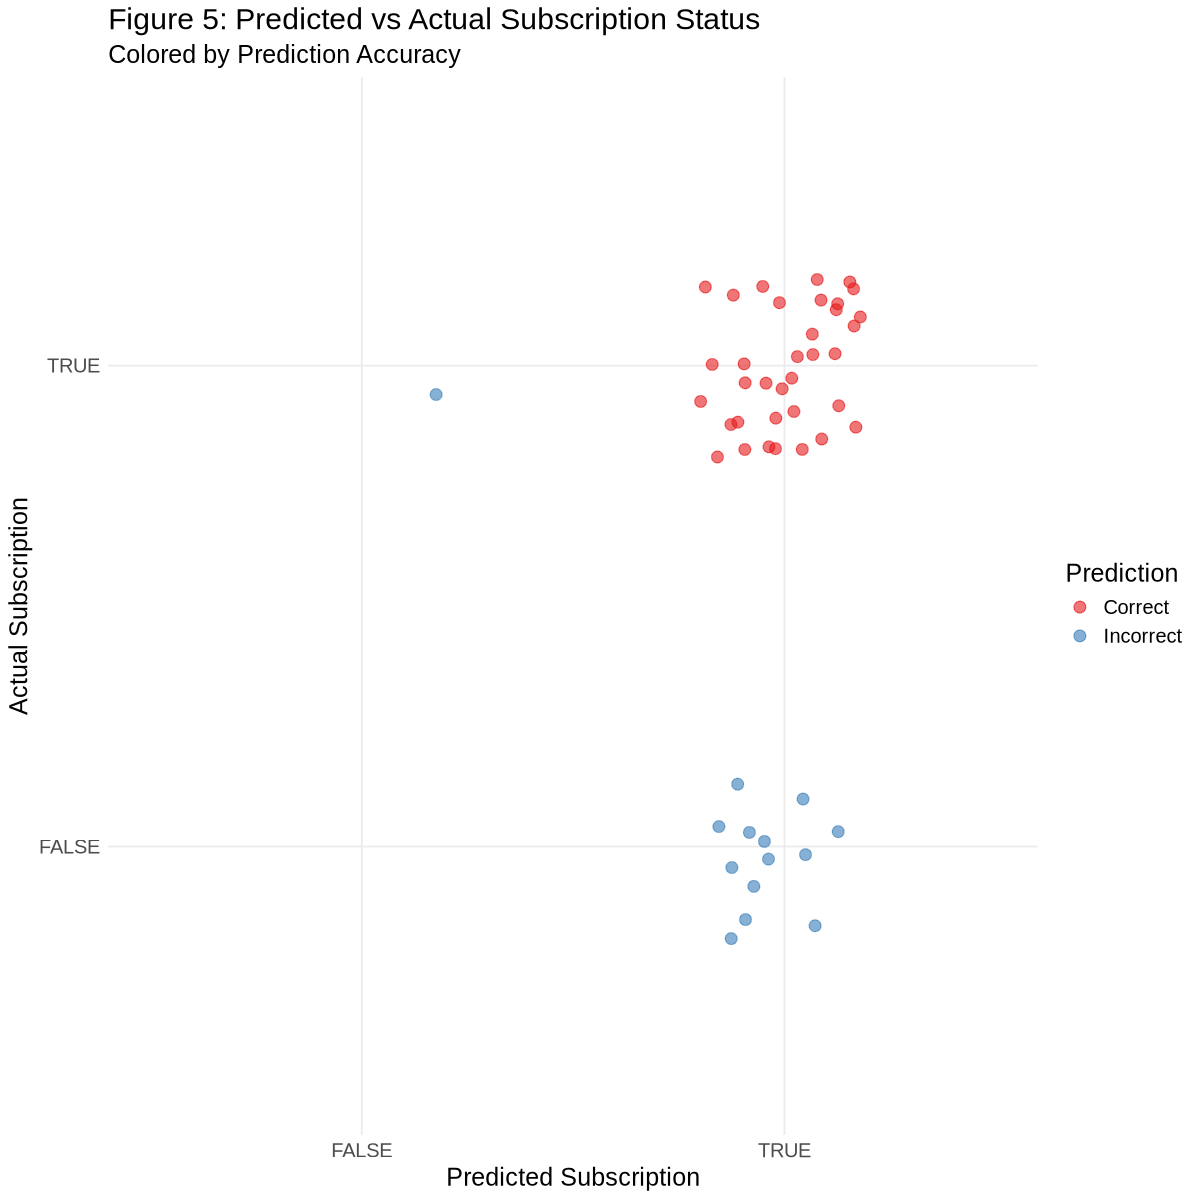

In [23]:
player_test_predictions <- player_test_predictions|>
  mutate(correct = if_else(.pred_class == subscribe, "Correct", "Incorrect"))

# Converting to factor
player_test_predictions$.pred_class <- as.factor(player_test_predictions$.pred_class)
player_test_predictions$subscribe <- as.factor(player_test_predictions$subscribe)
player_test_predictions$correct <- as.factor(player_test_predictions$correct)

# Creatng scatter plot
scatter_pred_vs_actual <- ggplot(player_test_predictions, aes(x = .pred_class, y = subscribe, color = correct)) +
  geom_jitter(width = 0.2, height = 0.2, size = 3, alpha = 0.6) +
  scale_color_brewer(palette = "Set1") +
  labs(
    title = "Figure 5: Predicted vs Actual Subscription Status",
    subtitle = "Colored by Prediction Accuracy",
    x = "Predicted Subscription",
    y = "Actual Subscription",
    color = "Prediction"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 15))


scatter_pred_vs_actual

In [26]:
options(repr.plot.width = 15, repr.plot.height = 6.5)
a1 <- ggplot(player_test_predictions, aes(x = Age, y = experience, color = subscribe)) +
  geom_point() +
  labs(x = "Age ", y = "experience ", color = "Subscribe(actual)",title="Figure 6: Age vs Experience (Actual)")
p1 <- ggplot(player_test_predictions, aes(x = Age, y = experience, color = .pred_class)) +
  geom_point() +
  labs(x = "Age ", y = "experience ", color = "Subscribe(predicted)", title = "Figure 7: Age vs Experience (Predicted)")
# Second scatter plot: Age vs played_hours
a2 <- ggplot(player_test_predictions, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(x = "Age ", y = "played hours ", color = "Subscribe(actual)", title = "Figure 8: Age vs Played Hours (Actual)")
p2 <- ggplot(player_test_predictions, aes(x = Age, y = played_hours, color = .pred_class)) +
  geom_point() +
  labs(x = "Age ", y = "played hours ", color = "Subscribe(predicted)", title = "Figure 9: Age vs Played Hours (Predicted)")
# Third scatter plot: experience vs played_hours
a3 <- ggplot(player_test_predictions, aes(x = experience, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(x = "experience ", y = "played hours ", color = "Subscribe(actual)", title = "Figure 10: Experience vs Played Hours (Actual)")
p3 <- ggplot(player_test_predictions, aes(x = experience, y = played_hours, color = .pred_class)) +
  geom_point() +
  labs(x = "experience ", y = "played hours ", color = "Subscribe(predicted)", title = "Figure11: Experience vs Played Hours (Predicted)")
# Arrange plots horizontally
grid.arrange(a1,p1, ncol = 2)
grid.arrange(a2,p2, ncol = 2)
grid.arrange(a3,p3, ncol = 2)


ERROR: Error in grid.arrange(a1, p1, ncol = 2): could not find function "grid.arrange"


### Discussion

After analysis, our model did not perform significantly better than our baseline, which predicts only one value for the subscribe class. This means that the predictors we chose (hours_played, experience_level, age) are not effective predictors to predict the target variable, which was whether players are subscribed to the game-related newsletter.

There is both an expected and unexpected aspect in the results we observed. During the exploratory analysis, we did discover that the predictor variables were not visibly correlated with the target variable, so it was expected that the model would not be able to easily find a pattern to predict the subscription status of the players. However, we did expect the model to draw out underlying relationships between the predictors once training took place, but the results suggest that is not what happened.

Since we found that the patterns drawn from player characteristics (hours_played, age, experience level) are ineffective in predicting the subscription status (our target variable), we may need to consider using other parts of the data to expand the modeling process. It may be helpful to create new variables in order to draw more information from the dataset. We could shift focus to collecting data such as in-game behaviour and engagement with game content.

Finding out which types of players are most likely to subscribe to the newsletter would allow us to adjust marketing strategies to increase subscription rates.

This analysis makes us wonder if there are other variables from the dataset (such as gender) that could better predict subscription status. Would player behaviour help make more accurate predictions? Could player feedback or satisfaction of the game correlate to subscription status?

### References